# LSTM Learning with TensorFlow

We will demonstrate fitting a recurrent neural network to a text file.

Based on https://github.com/skyer9/hello_lstm, ported to Jupyter notebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.rnn import BasicLSTMCell, GRUCell
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.seq2seq import sequence_loss

import numpy as np

In [2]:
#X_train = "Hello, World!"
# X_train = "안녕하세요, World!"
X_train = ("if you want to build a ship, don't drum up people together to "
           "collect wood and don't assign them tasks and work, but rather "
           "teach them to long for the endless immensity of the sea.")

#nb_epoches = 25
nb_epoches = 100
batch_size = 1
num_steps = 100 # Length of gradient unchaining

In [3]:
with open(r'd:\projects\gltestplus\src\gltestplus.cpp', encoding='utf-8') as f:
    text = f.read()
    #text = f.readlines()

X_train = text[:1000].replace('\r', '').replace('\n', '')
print(len(X_train))

960


In [4]:
def create_vocabulary(sequence):
    vocab = {}
    for i in range(len(sequence)):
        ch = sequence[i]
        if ch in vocab:
            vocab[ch] += 1
        else:
            vocab[ch] = 1
    vocab_rev = sorted(vocab, key=vocab.get, reverse=True)
    vocab = dict([(x, y) for (y, x) in enumerate(vocab_rev)])
    return vocab, vocab_rev


def sentence_to_token_ids(sentence, vocabulary):
    characters = [sentence[i:i+1] for i in range(0, len(sentence), 1)]
    return [vocabulary.get(w) for w in characters]


def token_ids_to_one_hot(token_ids, num_classes=10):
    token_ids_one_hot = np.zeros((len(token_ids), num_classes))
    token_ids_one_hot[np.arange(len(token_ids)), token_ids] = 1
    return token_ids_one_hot



In [5]:
sequence_length = len(X_train) - 1

X_train_vocab, X_train_vocab_rev = create_vocabulary(X_train)
hidden_size = len(X_train_vocab)
num_classes = len(X_train_vocab)

X_train_ids = sentence_to_token_ids(X_train, X_train_vocab)
X_data = X_train_ids[:-1]
Y_data = X_train_ids[1:]
X_data_one_hot = [token_ids_to_one_hot(X_data, num_classes)]
Y_data = [Y_data]



In [6]:
used = False

with tf.name_scope('lstm'):
    X = tf.placeholder(tf.float32, [None, sequence_length, hidden_size], name='X')
    Y = tf.placeholder(tf.int32, [None, sequence_length], name='Y')

    #cell = BasicLSTMCell(num_units=hidden_size)
    cell = GRUCell(num_units=hidden_size)
    initial_state = cell.zero_state(batch_size, tf.float32)
    outputs, _states = tf.nn.dynamic_rnn(cell,
                                         X,
                                         initial_state=initial_state,
                                         dtype=tf.float32)

    X_for_fc = tf.reshape(outputs, [-1, hidden_size])
    outputs = fully_connected(inputs=X_for_fc,
                              num_outputs=num_classes,
                              activation_fn=None)

    outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])

    weights = tf.ones([batch_size, sequence_length])
    sloss = sequence_loss(logits=outputs,
                                  targets=Y,
                                  weights=weights)
    loss = tf.reduce_mean(sloss)
    train = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)

    prediction = tf.argmax(outputs, axis=2)
    
    used = True
print(cell)

In [8]:
print(X_data_one_hot[0].shape, len(Y_data[0]), Y)

(959, 62) 959 Tensor("lstm/Y:0", shape=(?, 959), dtype=int32)


In [9]:
num_classes

62

In [10]:
tf.strided_slice?

In [11]:
sess = tf.Session()

In [12]:
nb_epoches = 1000
loss_hist = []

sess.run(tf.global_variables_initializer())
for i in range(nb_epoches):

    in2 = tf.train.range_input_producer(nb_epoches, shuffle=False).dequeue()  # [0, 1, .., epoch_size-1] という整数を順ぐりに無限生成するイテレータ
    if False:
        x = tf.strided_slice(X_data_one_hot[0], [0, in2 * num_steps],
                             [batch_size, (in2 + 1) * num_steps])  # この使われ方の strided_slice は、data[0:batch_size, i*num_steps:(i+1)*num_steps] だと思って良い
        x.set_shape([batch_size, num_steps])
        y = tf.strided_slice(Y_data[0], [in2 * num_steps],
                             [(in2 + 1) * num_steps])  # 正解 y は x の次に来る単語なので、1を足してスライスを右に一つずらす
        y.set_shape([num_steps])
    else:
        x = X_data_one_hot
        y = Y_data

    l, _ = sess.run([loss, train], feed_dict={X: x, Y: y})
    result = sess.run(prediction, feed_dict={X: x})
    print(i, "loss:", l) #, "prediction: ", result, "true Y: ", Y_data)
    result_str = [X_train_vocab_rev[c] for c in np.squeeze(result)]
    if i % 10 == 0:
        print("\tPrediction str: ", ''.join(result_str))
    loss_hist.append(l)

0 loss: 4.13354
	Prediction str:  iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii
1 loss

71 loss: nan
72 loss: nan
73 loss: nan
74 loss: nan
75 loss: nan
76 loss: nan
77 loss: nan
78 loss: nan
79 loss: nan
80 loss: nan
	Prediction str:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

151 loss: nan
152 loss: nan
153 loss: nan
154 loss: nan
155 loss: nan
156 loss: nan
157 loss: nan
158 loss: nan
159 loss: nan
160 loss: nan
	Prediction str:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

KeyboardInterrupt: 

In [ ]:
plt.semilogy(loss)

In [28]:
with tf.Session() as sess:
    result = sess.run(prediction, feed_dict={X: [token_ids_to_one_hot(np.random.randint(max(X_data), size=(sequence_length)), num_classes)]})
    for i in range(1000):
        sess.run(prediction, feed_dict={X: [token_ids_to_one_hot(resultX_data, num_classes)]})
    result_str = [X_train_vocab_rev[c] for c in np.squeeze(result)]
    print("\tPrediction str: ", ''.join(result_str))

FailedPreconditionError: Attempting to use uninitialized value rnn/basic_lstm_cell/kernel
	 [[Node: rnn/basic_lstm_cell/kernel/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](rnn/basic_lstm_cell/kernel)]]
	 [[Node: lstm/ArgMax/_3 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_183_lstm/ArgMax", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'rnn/basic_lstm_cell/kernel/read', defined at:
  File "D:\Programs\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Programs\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Programs\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Programs\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "D:\Programs\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "D:\Programs\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "D:\Programs\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Programs\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "D:\Programs\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Programs\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "D:\Programs\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Programs\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Programs\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Programs\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "D:\Programs\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Programs\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Programs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Programs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Programs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-3bb43a330d1d>", line 12, in <module>
    dtype=tf.float32)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn.py", line 574, in dynamic_rnn
    dtype=dtype)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn.py", line 737, in _dynamic_rnn_loop
    swap_memory=swap_memory)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2770, in while_loop
    result = context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2599, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2549, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn.py", line 722, in _time_step
    (output, new_state) = call_cell()
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn.py", line 708, in <lambda>
    call_cell = lambda: cell(input_t, state)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 180, in __call__
    return super(RNNCell, self).__call__(inputs, state)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 441, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 383, in call
    concat = _linear([inputs, h], 4 * self._num_units, True)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 1017, in _linear
    initializer=kernel_initializer)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1065, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 962, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 360, in get_variable
    validate_shape=validate_shape, use_resource=use_resource)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 183, in _rnn_get_variable
    variable = getter(*args, **kwargs)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 352, in _true_getter
    use_resource=use_resource)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 725, in _get_single_variable
    validate_shape=validate_shape)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 316, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1303, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "D:\Programs\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value rnn/basic_lstm_cell/kernel
	 [[Node: rnn/basic_lstm_cell/kernel/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](rnn/basic_lstm_cell/kernel)]]
	 [[Node: lstm/ArgMax/_3 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_183_lstm/ArgMax", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


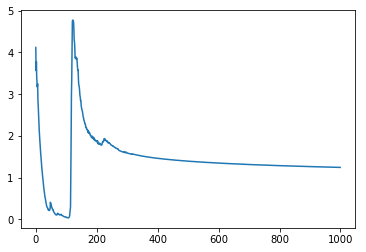

In [33]:
plt.plot(loss_hist)